In [251]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [252]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    runs_on_gpu = True
    from google.colab import drive
    drive.mount('/content/drive')
    directory = 'drive/MyDrive/'
else:
    device = torch.device('cpu')
    runs_on_gpu = False
    directory = ''
print(f"Runs on {device.type}")

Runs on cpu


In [253]:
# Load data
data = pd.read_json('recipes.json')
data.dropna(subset=['rating'], inplace=True, ignore_index=True)
print(data.dropna(how='any', inplace=False, ignore_index=True).shape)
data.info()

(10608, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20100 entries, 0 to 20099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   directions   20100 non-null  object             
 1   fat          15901 non-null  float64            
 2   date         20100 non-null  datetime64[ns, UTC]
 3   categories   20100 non-null  object             
 4   calories     15969 non-null  float64            
 5   desc         13484 non-null  object             
 6   protein      15922 non-null  float64            
 7   rating       20100 non-null  float64            
 8   title        20100 non-null  object             
 9   ingredients  20100 non-null  object             
 10  sodium       15967 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), object(5)
memory usage: 1.7+ MB


In [254]:
data.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


In [255]:
# safe some column names for easier access later
mandatory_columns = ['directions', 'date', 'categories', 'title', 'ingredients']
optional_columns = ['fat', 'calories', 'desc', 'protein', 'sodium']
numerical_columns = ['fat', 'calories', 'protein', 'sodium']
textual_columns = ['title', 'desc', 'directions']
list_columns = ['categories', 'ingredients', 'directions']

In [256]:
# add some numerical features
for column in list_columns:
    data[f'num_{column}'] = data[column].apply(lambda x: len(x))
data.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium,num_categories,num_ingredients,num_directions
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0,11,15,3
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0,11,28,5
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0,7,6,2
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN,17,10,2
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0,11,6,1


In [257]:
# fill missing values and convert list column to string
data['desc'] = data['desc'].fillna('')
assert(data['desc'].isna().sum() == 0)

data['directions'] = data['directions'].apply(lambda x: ' '.join(x))
assert(data['directions'].isna().sum() == 0)

In [258]:
# normalize numerical columns for better training
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

<Axes: xlabel='rating'>

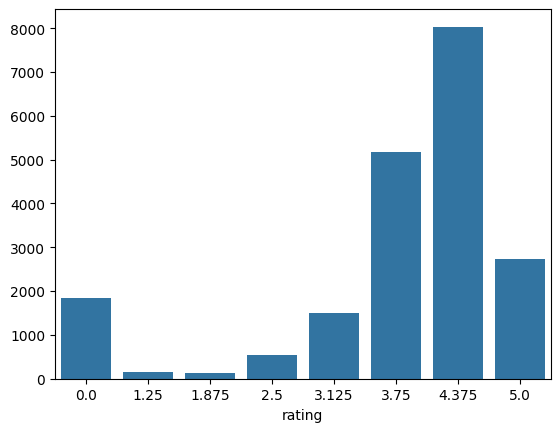

In [259]:
# rating is a categorical variable and its very skewed
ratings = data['rating']
data.drop(columns=['rating'])
rating_value_counts = ratings.value_counts()
sns.barplot(x=rating_value_counts.index, y=rating_value_counts.values)

# 3 Basic Project
The basic project will consist of solving a regression task, comparing the performance obtained using different vectorizations of the documents and at least two different machine learning strategies, as described below. 

You should use the information in the directions and/or desc variables for all steps of the project, possibly combining this information with metadata from other variables. You should use appropriate metrics for evaluating this task. The performance of the different methods should be estimated using a validation methodology, which you should also explain in the documentation. You should provide a description of the methodology used and analyze the performance obtained according to the input variables.
Keep in mind that the goal is to describe the work carried out and critically analyze the results obtained. Support this with graphs or other representations you consider appropriate. There is no need to describe the algorithms used, but you should explain how you tuned their parameters.

## 3.1
Analysis of input variables. Visualize the relationship between the output variable and some categories in the categories variable and explain their potential relevance to the problem.

In [260]:
import matplotlib.pyplot as plt

In [261]:
# get all existing categories in a list
all_categories = data['categories'].explode().unique().tolist()
print(len(all_categories))

675


In [262]:
# convert the lists of categories to a binary matrix (also called dummy encoding)
categories = {category: data['categories'].apply(lambda x: 1 if category in x else 0) for category in all_categories}
assert(len(categories) == len(all_categories))

In [263]:
# create a dataframe with all categories and the rating
categories_and_rating = pd.DataFrame(categories)
categories_and_rating['rating'] = data['rating']
#categories_and_rating.columns = [f"{category} ({(categories_and_rating[category]).sum()})" for category in all_categories] + ['rating']
categories_and_rating

,Sandwich,Bean,Fruit,Tomato,turkey,Vegetable,Kid-Friendly,Apple,Lentil,Lettuce,...,Quiche,Anthony Bourdain,Marinade,Pacific Palisades,Alaska,Mississippi,Crêpe,New Hampshire,Sourdough,rating
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,2.500
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.375
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.750
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.000
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.125
20096,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4.375
20097,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4.375
20098,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.375


In [264]:
# calculate the distribution of ratings so we can normalize the dataset in the next step
grouped_by_rating = categories_and_rating.groupby(['rating'])
normalizer = grouped_by_rating.size() / len(categories_and_rating)
assert(abs(normalizer.sum() - 1)  < 0.001)
normalizer

rating
0.000    0.091990
1.250    0.008159
1.875    0.006169
2.500    0.026667
3.125    0.074080
3.750    0.257413
4.375    0.399652
5.000    0.135871
dtype: float64

In [265]:
# to normalize the data we use the normalizer and we divide by the sum of the column so its not important how many occurences of a category there are, only the relative distribution
normalize_column = lambda x: x / normalizer / (x / normalizer).sum()
relations = grouped_by_rating.sum().apply(normalize_column)
relations = relations.astype(float)
print(relations.info())
relations

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 0.0 to 5.0
Columns: 675 entries, Sandwich to Sourdough
dtypes: float64(675)
memory usage: 42.2 KB
None


,Sandwich,Bean,Fruit,Tomato,turkey,Vegetable,Kid-Friendly,Apple,Lentil,Lettuce,...,Germany,Quiche,Anthony Bourdain,Marinade,Pacific Palisades,Alaska,Mississippi,Crêpe,New Hampshire,Sourdough
rating,,,,,,,,,,,,,,,,,,,,,
0.000,0.122039,0.070554,0.083406,0.077012,0.143805,0.048911,0.168234,0.099242,0.083330,0.073780,...,1.0,1.0,0.224738,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1.250,0.148747,0.106060,0.137811,0.076611,0.085332,0.088230,0.135481,0.109695,0.000000,0.083182,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1.875,0.147548,0.210409,0.117937,0.135100,0.000000,0.194486,0.115943,0.232129,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.500,0.113781,0.129805,0.143860,0.106786,0.104436,0.141728,0.124359,0.107403,0.143728,0.229061,...,0.0,0.0,0.775262,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.125,0.069629,0.131418,0.125893,0.148135,0.117482,0.172491,0.100943,0.106321,0.206953,0.128265,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3.750,0.121407,0.146237,0.123080,0.170794,0.120362,0.156845,0.102054,0.116827,0.275455,0.147651,...,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4.375,0.149562,0.141827,0.146799,0.164924,0.167244,0.132845,0.105106,0.136162,0.191804,0.173219,...,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5.000,0.127288,0.063690,0.121215,0.120638,0.261339,0.064463,0.147880,0.092222,0.098731,0.164841,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<Axes: xlabel='corr', ylabel='count'>

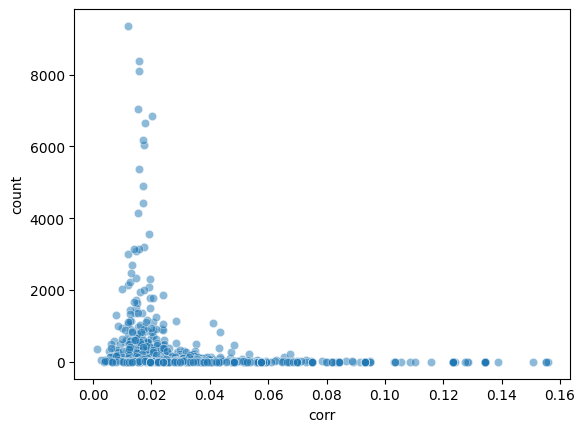

In [266]:
#calculate the difference between the rating and the mean rating for each category, so we can see which categories have an impact on the rating
correlation = ((relations - normalizer.to_numpy().reshape(-1,1)) ** 2).mean()
correlation.sort_values(ascending=False)
#combine that with the number of recipes in each category, so we can see if the correlation is significant
correlation = correlation.to_frame()
correlation.columns = ['corr']
correlation['count'] = categories_and_rating.sum()
sns.scatterplot(x='corr', y='count', data=correlation, alpha=0.5)

In [267]:
max_corr = correlation['corr'].max()
print(f"Max correlation is: {max_corr}")

Max correlation is: 0.1558588945818173


<Axes: ylabel='rating'>

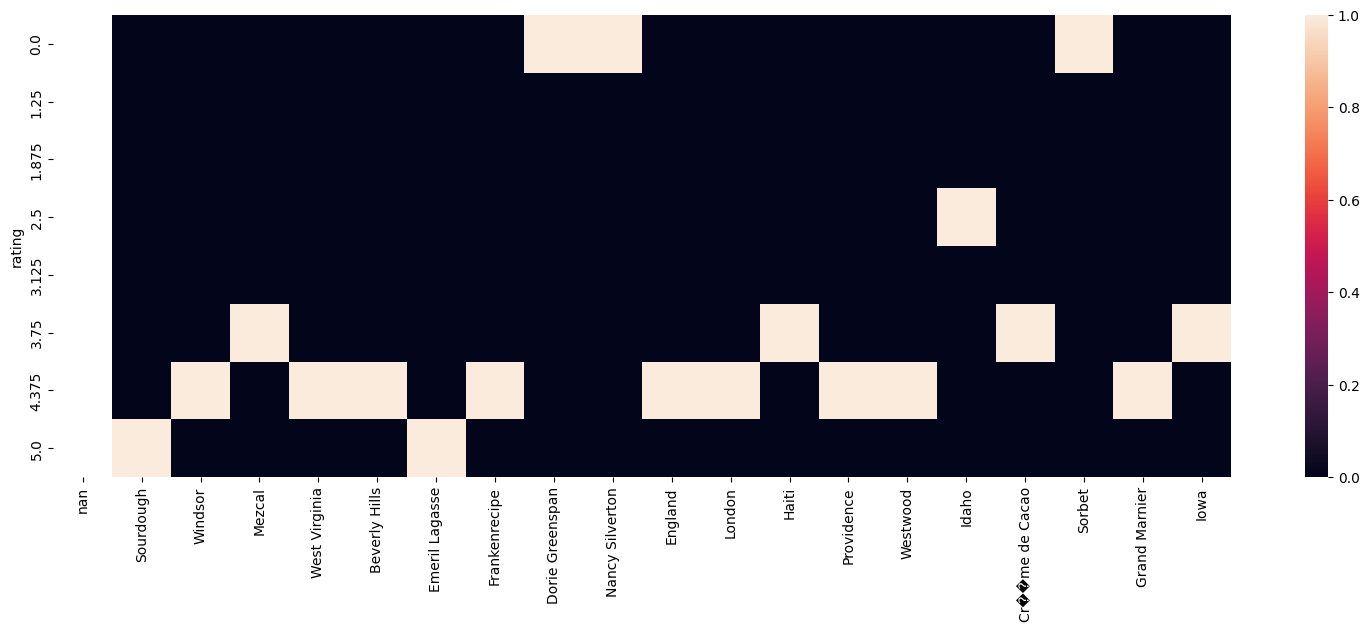

In [268]:
display_columns = correlation.sort_values(by='count', ascending=True).head(20)
plt.figure(figsize=(19, 6))
sns.heatmap(relations[display_columns.index])

<Axes: ylabel='rating'>

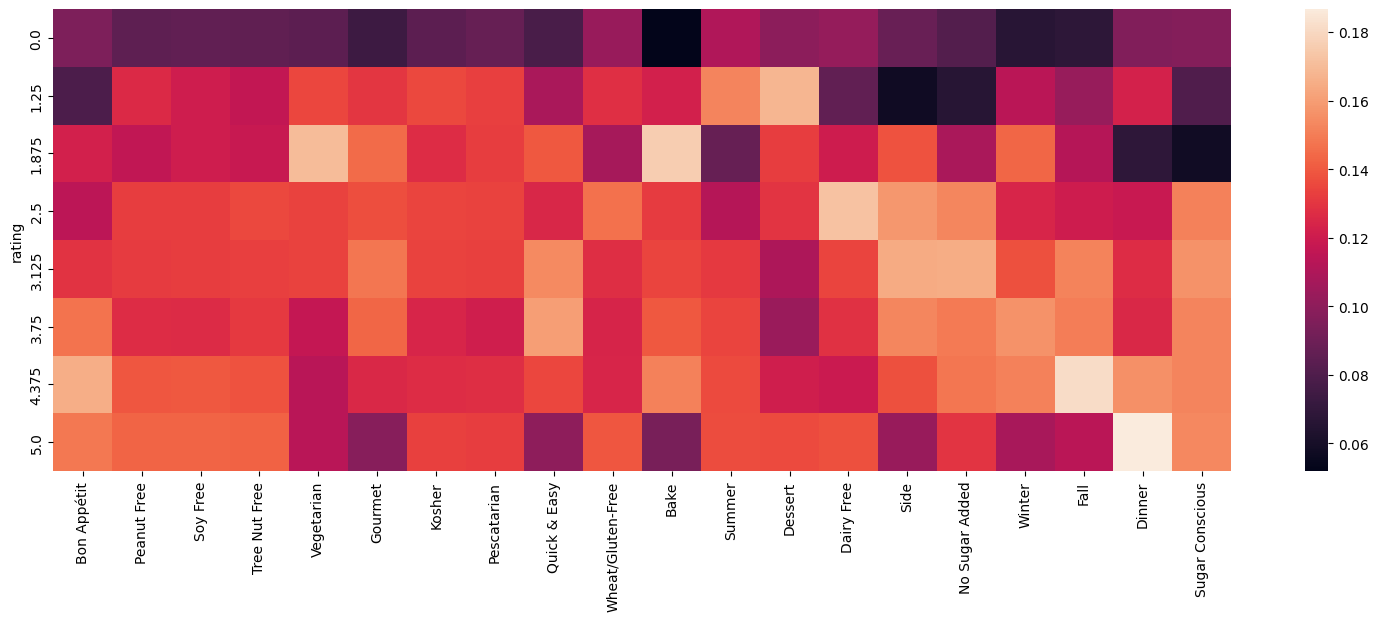

In [270]:
display_columns = correlation.sort_values(by='count', ascending=False).head(20)
plt.figure(figsize=(19, 6))
sns.heatmap(relations[display_columns.index])

48 20052


<Axes: ylabel='rating'>

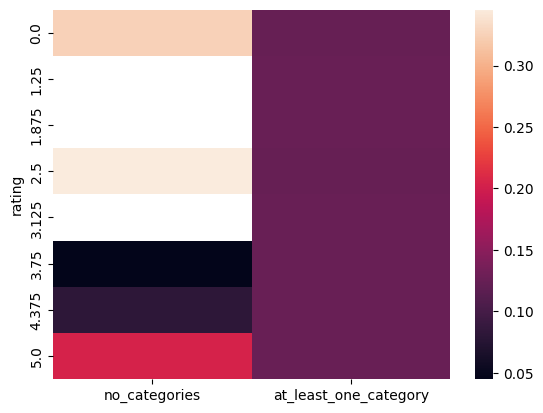

In [271]:
no_categories = data[data['num_categories'] == 0]
at_least_one_category = data[data['num_categories'] > 0]
print(len(no_categories), len(at_least_one_category))
no_categories = no_categories.groupby('rating').size()
at_least_one_category = at_least_one_category.groupby('rating').size()
combined = pd.DataFrame({'no_categories': no_categories, 'at_least_one_category': at_least_one_category}).apply(normalize_column)
sns.heatmap(combined)

<Axes: ylabel='rating'>

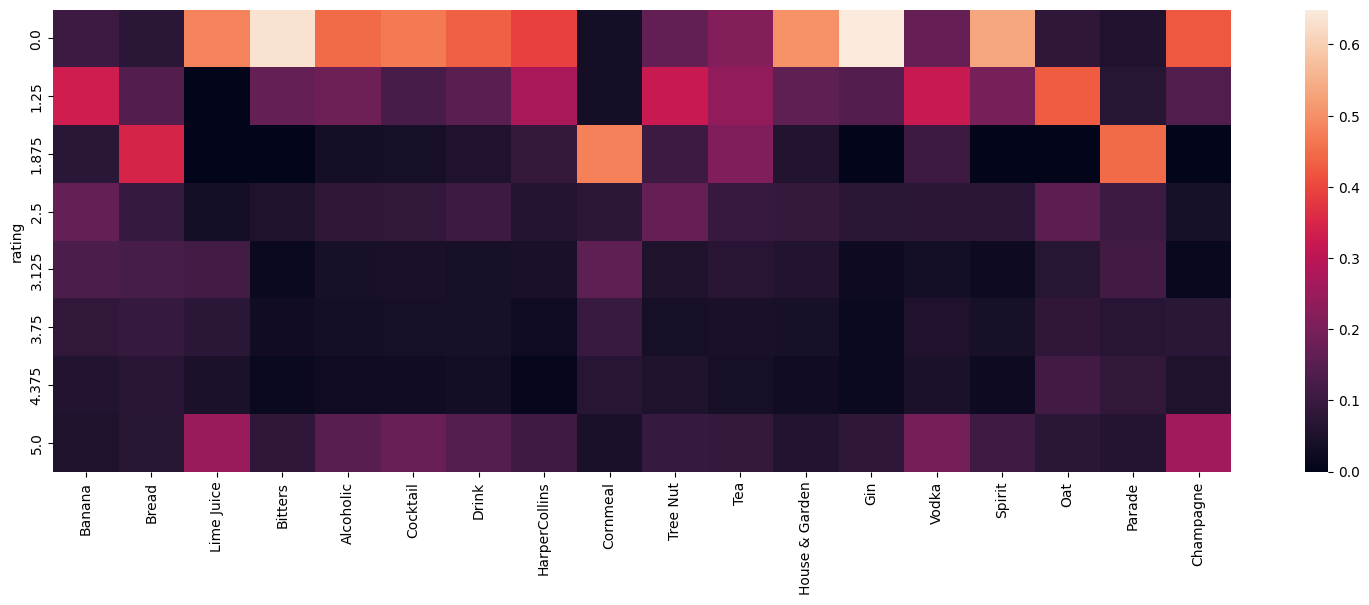

In [273]:
significant_columns = correlation[(correlation['count'] > 100) & (correlation['corr'] > 0.035)]
plt.figure(figsize=(19, 6))
sns.heatmap(relations[significant_columns.index])

<Axes: ylabel='rating'>

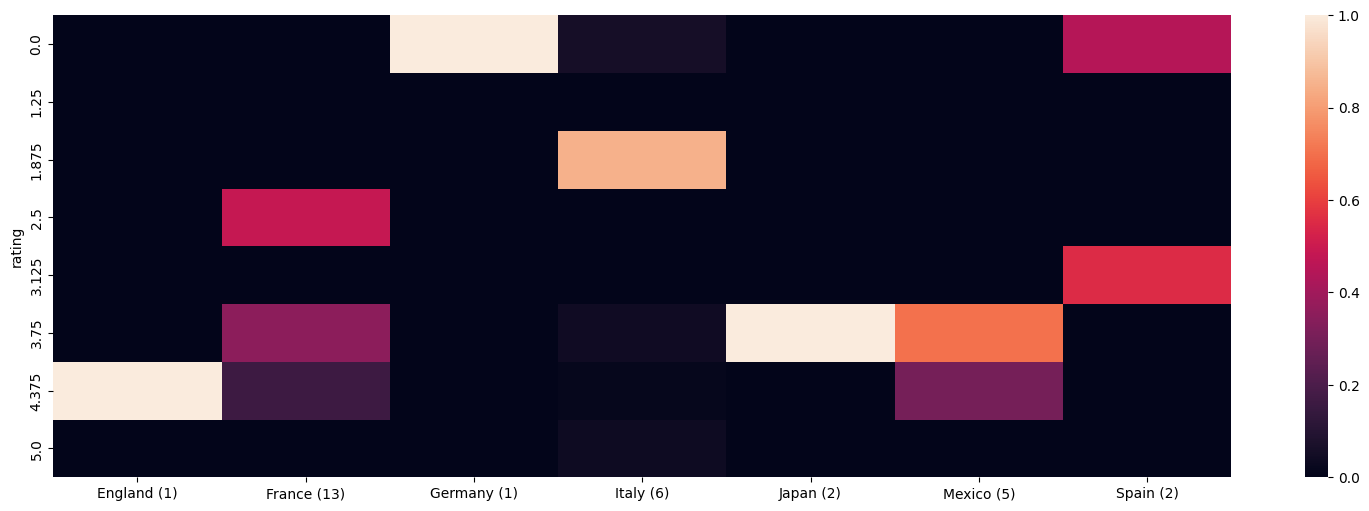

In [275]:
display_columns = ['England', 'France', 'Germany', 'Italy', 'Japan', 'Mexico', 'Spain']
occurrences = categories_and_rating[display_columns].sum()
displayed_names = [f"{country} ({occurrences[country]})" for country in display_columns]
plt.figure(figsize=(19, 6))
sns.heatmap(relations[display_columns], xticklabels=displayed_names)

[9.01962390e-01 9.50294964e-02 2.99814964e-03 9.96439782e-06]
[[ 0.51497528  0.52123688  0.43833303  0.52055425]
 [-0.30493785 -0.23833489  0.89670978 -0.21475788]
 [-0.67203448 -0.02397247 -0.05819634  0.7378402 ]
 [-0.43609979  0.81910556 -0.01972056 -0.37214803]]


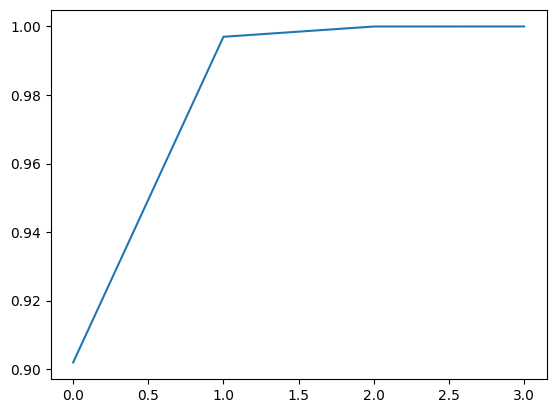

In [204]:
# we do a PCA to see if we can reduce the number of dimensions
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data[numerical_columns].dropna())
sns.lineplot(x=range(len(pca.explained_variance_ratio_)), y=np.cumsum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_) # the first component explains 99% of the variance
print(pca.components_)

In [205]:
# we impute the nan values with the mean, so we can use the PCA to reduce the number of dimensions to one
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
data[numerical_columns] = imp.fit_transform(data[numerical_columns])

In [206]:
data['numerical_columns'] = pca.transform(data[numerical_columns])[:,0]
data['numerical_columns_2'] = pca.transform(data[numerical_columns])[:,1]
data.drop(columns=numerical_columns, inplace=True)

In [207]:
data.to_json(directory+'preprocessed_recipes.json')

## 3.2
Implementation of a pipeline for text preprocessing. For this task, you may use common libraries (NLTK, Gensim, or SpaCy), or any other library you deem appropriate. Keep in mind that when working with transformers, the text is passed without preprocessing.

In [208]:
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [209]:
stop_words = set(stopwords.words('english'))
lemmatizer=WordNetLemmatizer()

In [210]:
def nltk_pos_tagger(nltk_tag): #Method copied from: https://www.holisticseo.digital/python-seo/nltk/lemmatize
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# preprocessing of a string 
def preprocessing(text):
	all_words = []

	text = text.translate(str.maketrans('', '', string.punctuation)) #Remove punctuation
	text = text.translate(str.maketrans('', '', string.digits)) #Remove numbers

	for sentence in sent_tokenize(text):
		words = []
		nltk_tagged = nltk.pos_tag(word_tokenize(sentence)) #POS tagging so that we can lemmatize
		wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged) #map the POS tags from nltk to wordnet tags
	
		for word, tag in wordnet_tagged: #Iterate over the words
			lemmatized_word = word
			if not tag is None:
				lemmatized_word = lemmatizer.lemmatize(lemmatized_word, tag)	#Lemmatize the word
			if (not lemmatized_word.isnumeric()) and (lemmatized_word not in stop_words): #Remove stopwords and numbers
				words.append(lemmatized_word)
		all_words.append(words)
	return all_words

## 3.3
Vector representation of the documents using three different procedures:

### TF-IDF

In [211]:
from sklearn.feature_extraction.text import TfidfVectorizer
# nltk.download('stopwords')
# nltk.download('wordnet')
#nltk.download('punkt_tab')
#nltk.download('averaged_perceptron_tagger_eng')

In [212]:
def flatten(xss): #method from: https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
    return [x for xs in xss for x in xs]

def get_tfidf_matrix(data):
    tfidf_vectorizer = TfidfVectorizer(min_df=0.005) #max_df doesn't really do anything here - min_df==0.005 means about 100 times

    joined_textual_columns = data[textual_columns].apply(lambda x: ' '.join(x), axis=1) #Join the textual columns
    joined_textual_columns = joined_textual_columns.apply(preprocessing) #Preprocess the text
    joined_textual_columns = joined_textual_columns.apply(lambda x: ' '.join(flatten(x))) #Flatten the list of lists to a list of strings

    tfidf_matrix = tfidf_vectorizer.fit_transform(joined_textual_columns) #Fit the vectorizer and transform the text
    
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) #Convert the matrix to a dataframe
    return tfidf_df

In [213]:
if not runs_on_gpu:
    tfidf = get_tfidf_matrix(data) 
    tfidf.to_pickle(directory+'tfidf.pkl')
    print(tfidf.head())
    print(tfidf.columns)

   absorb  accompaniment  accompany  accord  accumulate  accumulated  across  \
0     0.0            0.0        0.0     0.0         0.0          0.0     0.0   
1     0.0            0.0        0.0     0.0         0.0          0.0     0.0   
2     0.0            0.0        0.0     0.0         0.0          0.0     0.0   
3     0.0            0.0        0.0     0.0         0.0          0.0     0.0   
4     0.0            0.0        0.0     0.0         0.0          0.0     0.0   

   active       add  addition  ...  yield  yogurt  yolk  york  you  youll  \
0     0.0  0.028909       0.0  ...    0.0     0.0   0.0   0.0  0.0    0.0   
1     0.0  0.202181       0.0  ...    0.0     0.0   0.0   0.0  0.0    0.0   
2     0.0  0.042508       0.0  ...    0.0     0.0   0.0   0.0  0.0    0.0   
3     0.0  0.122710       0.0  ...    0.0     0.0   0.0   0.0  0.0    0.0   
4     0.0  0.000000       0.0  ...    0.0     0.0   0.0   0.0  0.0    0.0   

   youre  youve  zest  zucchini  
0    0.0    0.0   0.0 

### Word2Vec (i.e., representing the documents as the average of the embeddings of the words that make them up)
Punktuation filter from: https://medium.com/product-ai/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908

In [214]:
from gensim.models import Word2Vec

In [243]:
def get_word2vec_for_text(text):
	all_words = preprocessing(text)

	model = Word2Vec(all_words, min_count=1, vector_size=500, workers=16) #Create a word2vec model

	return model.wv #Return the word vectors from the model

def get_avrg_word2vec(text):
	if(text.strip() == ''): #Make sure that the text is not empty
		return pd.NA

	word_vectors = get_word2vec_for_text(text) 

	return np.mean(word_vectors.vectors, axis=0, dtype='float32') # We average the word vectors to get a single vector for the text so there is less data, we hope that the average is a good representation

def get_word2vec(data):
	joined_textual_columns = data[textual_columns].apply(lambda x: ' '.join(x), axis=1)
	avrg_word2vec = list()
	for text in joined_textual_columns:
		avrg_word2vec.append(get_avrg_word2vec(text))

	return np.array(avrg_word2vec, dtype='float32')

In [244]:
if not runs_on_gpu:
    word2vec = get_word2vec(data)
    np.save("word2vec.npy", word2vec)
    print(word2vec.shape)

(20100, 500)


### Contextual embeddings calculated from transformer-based models (e.g., BERT, RoBERTa, etc.)

In [217]:
from transformers import BertModel, BertTokenizer

In [218]:
def prepare_input(texts, tokenizer):
    return tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

# The method gets a text and a model and returns the context embedding of the text
def get_context_embeddings_batch(texts, model, tokenizer, batch_size=450): #batch size is 450 because this is the maximum that fits on the GPU of colab
    all_embeddings = []
    for i in range(0, len(texts), batch_size): # we iterate over the texts in batches, so we don't run out of memory on the GPU
        print(i)
        batch_texts = texts[i:i + batch_size]   # Get the next batch of texts
        inputs = prepare_input(batch_texts, tokenizer) # tokenizes the texts
        inputs = inputs.to(device) # moves the inputs to the GPU
        
        with torch.no_grad(): # we just use the model for inference, so we don't need to calculate the gradients like for training
            outputs = model(**inputs) 
        embeddings = outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy() # we take the mean of the embeddings of the tokens in the text and hope that this is a good representation of the text
        all_embeddings.extend(embeddings)
    
    return np.array(all_embeddings, dtype='float32')

def join_textual_columns(row):
    return f"Title: '{row['title']}'\nDescription: '{row['desc']}'\nDirections: '{row['directions']}'" # we join the textual columns to one text with some formatting, in hope the transformer can improve the embeddings

def get_context_embedding_for_text_columns(data):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.to(device)
    
    joined_textual_columns = data.apply(join_textual_columns, axis=1)

    texts = joined_textual_columns.tolist()  # Convert to list for batch processing
    embeddings = get_context_embeddings_batch(texts, model, tokenizer)
        
    return np.array(embeddings)

In [219]:
if runs_on_gpu:
    context_embedding = get_context_embedding_for_text_columns(data)
    np.save(directory+"context_embedding.npy", context_embedding)
else:
    context_embedding = get_context_embedding_for_text_columns(data.sample(5))
context_embedding.shape

0


(5, 768)